In [4]:
# 1. Install Library
!pip install transformers datasets accelerate scikit-learn openpyxl -q

# 2. Unzip Dataset MIR (Biar folder Q3/Q4 keluar)
import os
import shutil

if os.path.exists('/content/lyrics.zip'):
    print("Mengekstrak dataset MIR...")
    !unzip -q /content/lyrics.zip -d /content/MERGE_Bimodal_Balanced
    print("Selesai ekstrak.")
else:
    print("⚠️ WARNING: File lyrics.zip belum diupload!")

Mengekstrak dataset MIR...
Selesai ekstrak.


📂 Loading MIR Dataset dari: /content/MERGE_Bimodal_Balanced
   └─ Folder 'Q3': 500 lagu.
   └─ Folder 'Q4': 500 lagu.

📂 Loading Excel User dari: lyrics.xlsx
   └─ Ditemukan: 50 Sad, 50 Relaxed.

✂️ Membagi Data (Split) sebelum Boosting...
🚀 Boosting HANYA pada Data Training User (5x)...

✅ Total Data Training : 1200
✅ Total Data Validasi : 220 (Aman dari Leakage)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


⚙️ Memuat Model roberta-base...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
classifier.out_proj.weight      | MISSING    | 
classifier.dense.bias           | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.bias        | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.



--- MULAI TRAINING ROBERTA VERSION ---


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.691735,0.564243,0.795455,0.794738
2,0.499146,0.489931,0.777273,0.777158
3,0.365232,0.496798,0.809091,0.808838
4,0.271176,0.534855,0.827273,0.826570


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.691735,0.564243,0.795455,0.794738
2,0.499146,0.489931,0.777273,0.777158
3,0.365232,0.496798,0.809091,0.808838
4,0.271176,0.534855,0.827273,0.826570
5,0.238889,0.540162,0.822727,0.822636


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye


--- Evaluasi Akhir (Detailed Metrics) ---



🎯 Akurasi Final (Validasi): 82.73%

📝 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Sad (Q3)       0.79      0.89      0.84       110
Relaxed (Q4)       0.88      0.76      0.82       110

    accuracy                           0.83       220
   macro avg       0.83      0.83      0.83       220
weighted avg       0.83      0.83      0.83       220



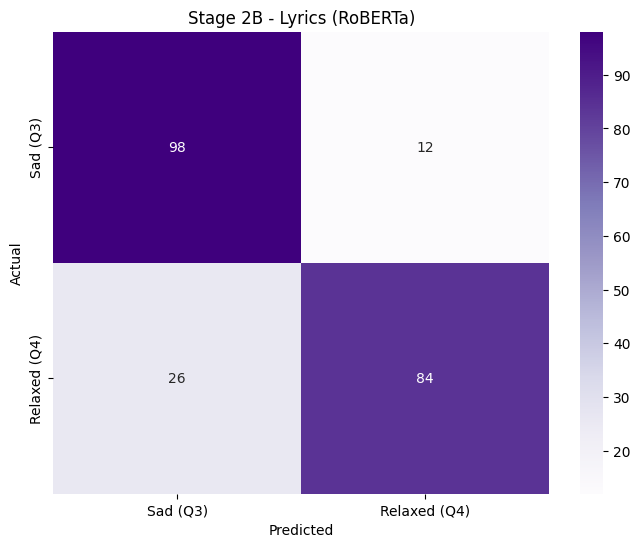

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


✅ Model dan Tokenizer berhasil disimpan di folder './model_roberta_stage2b'


In [5]:
!pip install -q transformers datasets scikit-learn mlflow seaborn openpyxl accelerate

# ==============================================================================
# STAGE 2B LYRICS TRAINING - ROBERTA VERSION (ANTI-LEAKAGE + MLFLOW + METRICS)
# ==============================================================================
# --- 0. INSTALL DEPENDENCIES ---
!pip install transformers datasets accelerate scikit-learn mlflow openpyxl -q

import pandas as pd
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
import mlflow
import mlflow.pytorch

# ==========================================
# --- 1. KONFIGURASI ---
# ==========================================
MIR_DATA_PATH = '/content/MERGE_Bimodal_Balanced'
USER_EXCEL_PATH = 'lyrics.xlsx'

# 🔥 GANTI MODEL KE ROBERTA BASE
MODEL_NAME = 'roberta-base'
BOOST_FACTOR = 5

# MLflow Setup
mlflow.set_tracking_uri("file:///content/mlruns")
mlflow.set_experiment("Hierarchical_Stage2B_Lyrics_RoBERTa")

# ==========================================
# --- 2. LOAD MIR DATA ---
# ==========================================
def load_mir_dataset(path):
    texts = []
    labels = []
    mapping = {'Q3': 0, 'Q4': 1}

    print(f"📂 Loading MIR Dataset dari: {path}")

    for folder, label in mapping.items():
        paths_to_check = [
            os.path.join(path, folder),
            os.path.join(path, 'lyrics', folder)
        ]

        found_path = None
        for p in paths_to_check:
            if os.path.exists(p):
                found_path = p
                break

        if found_path:
            files = [f for f in os.listdir(found_path) if f.endswith('.txt')]
            print(f"   └─ Folder '{folder}': {len(files)} lagu.")

            for f in files:
                try:
                    with open(os.path.join(found_path, f), 'r', encoding='utf-8') as tf:
                        lyric = tf.read().replace('\n', ' ').strip()
                        if len(lyric) > 10:
                            texts.append(lyric)
                            labels.append(label)
                except:
                    pass

    return texts, labels


# ==========================================
# --- 3. LOAD USER EXCEL ---
# ==========================================
def load_user_excel(path):
    texts = []
    labels = []

    print(f"\n📂 Loading Excel User dari: {path}")

    if not os.path.exists(path):
        print(f"⚠️ File Excel tidak ditemukan: {path}. Melewati data user...")
        return [], []

    try:
        df = pd.read_excel(path)
        df.columns = [c.lower() for c in df.columns]

        if 'lyrics' not in df.columns or 'mood' not in df.columns:
            print("⚠️ Kolom 'lyrics' atau 'mood' tidak ditemukan!")
            return [], []

        count_sad = 0
        count_relaxed = 0

        for _, row in df.iterrows():
            lyric = str(row['lyrics']).replace('\n', ' ').strip()
            mood = str(row['mood']).lower().strip()

            label = -1
            if mood in ['sad', 'sedih', 'galau']:
                label = 0
                count_sad += 1
            elif mood in ['relaxed', 'relax', 'santai', 'tenang']:
                label = 1
                count_relaxed += 1

            if label != -1 and len(lyric) > 10:
                texts.append(lyric)
                labels.append(label)

        print(f"   └─ Ditemukan: {count_sad} Sad, {count_relaxed} Relaxed.")
        return texts, labels
    except Exception as e:
        print(f"❌ Error baca Excel: {e}")
        return [], []


# ==========================================
# --- 4. SPLIT & BOOST (ANTI LEAKAGE) ---
# ==========================================
mir_texts, mir_labels = load_mir_dataset(MIR_DATA_PATH)
user_texts, user_labels = load_user_excel(USER_EXCEL_PATH)

print("\n✂️ Membagi Data (Split) sebelum Boosting...")

mir_train_t, mir_val_t, mir_train_l, mir_val_l = train_test_split(
    mir_texts, mir_labels,
    test_size=0.2,
    stratify=mir_labels,
    random_state=42
)

if len(user_texts) > 0:
    user_train_t, user_val_t, user_train_l, user_val_l = train_test_split(
        user_texts, user_labels,
        test_size=0.2,
        stratify=user_labels,
        random_state=42
    )

    print(f"🚀 Boosting HANYA pada Data Training User ({BOOST_FACTOR}x)...")

    boosted_user_train_t = user_train_t * BOOST_FACTOR
    boosted_user_train_l = user_train_l * BOOST_FACTOR

    train_texts = mir_train_t + boosted_user_train_t
    train_labels = mir_train_l + boosted_user_train_l

    val_texts = mir_val_t + user_val_t
    val_labels = mir_val_l + user_val_l
else:
    print("⚠️ Data Excel kosong, training murni menggunakan data MIR.")
    train_texts, train_labels = mir_train_t, mir_train_l
    val_texts, val_labels = mir_val_t, mir_val_l

train_combined = list(zip(train_texts, train_labels))
random.shuffle(train_combined)
train_texts, train_labels = zip(*train_combined)

train_texts = list(train_texts)
train_labels = list(train_labels)

print(f"\n✅ Total Data Training : {len(train_texts)}")
print(f"✅ Total Data Validasi : {len(val_texts)} (Aman dari Leakage)")


# ==========================================
# --- 5. TOKENIZER ---
# ==========================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)


class LyricsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = LyricsDataset(train_encodings, train_labels)
val_dataset = LyricsDataset(val_encodings, val_labels)


# ==========================================
# --- 6. MODEL ROBERTA ---
# ==========================================
print("\n⚙️ Memuat Model roberta-base...")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

# Freeze 2 layer bawah saja
for i in range(2):
    for param in model.roberta.encoder.layer[i].parameters():
        param.requires_grad = False

model.config.hidden_dropout_prob = 0.3
model.config.attention_probs_dropout_prob = 0.3


# ==========================================
# --- 7. TRAINING ---
# ==========================================
training_args = TrainingArguments(
    output_dir='./results_roberta',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.05,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    label_smoothing_factor=0.1,
    logging_steps=50,
    report_to="mlflow" # Aktifkan MLflow
)


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("\n--- MULAI TRAINING ROBERTA VERSION ---")
with mlflow.start_run(run_name="Stage2B_RoBERTa_Run"):
    trainer.train()

    # ==========================================
    # --- 8. EVALUASI AKHIR & VISUALISASI ---
    # ==========================================
    print("\n--- Evaluasi Akhir (Detailed Metrics) ---")
    res = trainer.evaluate()
    print(f"\n🎯 Akurasi Final (Validasi): {res['eval_accuracy']*100:.2f}%")

    # Ambil prediksi untuk laporan detail
    predictions = trainer.predict(val_dataset)
    y_pred = predictions.predictions.argmax(-1)
    y_true = predictions.label_ids

    # Classification Report
    target_names = ['Sad (Q3)', 'Relaxed (Q4)']
    print("\n📝 CLASSIFICATION REPORT:")
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=target_names, yticklabels=target_names)
    plt.title('Stage 2B - Lyrics (RoBERTa)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('cm_stage2b_roberta.png')
    plt.show()

    # Log Artifact ke MLflow
    mlflow.log_artifact('cm_stage2b_roberta.png')

# Simpan Model Pokok
trainer.save_model("./model_roberta_stage2b")
tokenizer.save_pretrained("./model_roberta_stage2b")
print("\n✅ Model dan Tokenizer berhasil disimpan di folder './model_roberta_stage2b'")

In [6]:
import shutil
from google.colab import files

# Zipping folder mlruns
shutil.make_archive('mlruns_export', 'zip', 'mlruns')

# Mendownload file zip tersebut
files.download('mlruns_export.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>